<a href="https://colab.research.google.com/github/irungus/Dessertation/blob/main/Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

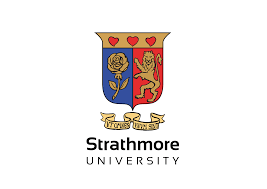

# Project Title

Optimizing agroforestry for climate resilience: A data-driven approach to mitigating environmental shocks and enhancing ecosystem stability

# Objective of the Study
The Objective is to develop machine learning models for optimizing agroforestry systems through species identification, classification, and Carbon sequestration valuation to enhance climate change mitigation and adaptation.

i.	Assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change.

ii.	To develop machine learning models for species identification and classification within agroforestry systems, enhancing biodiversity management.

iii. To develop a smart decision support system that combines ecological, climate, and species data, providing actionable recommendations in real time to farmers based on climate predictions, soil data, and agroforestry performance metrics.


# Introduction

We will first assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change. This will be done by calculating the Above Ground Biomass (AGB) using the data collected from the field and existing knowledge on how to calculate the AGB.

We are going to use traditional methods of calculating AGB famously know as Allometric equations and compare them with using various Machine Learning Algorithims. In short we will be comparing the allometric models to machine learning algorithms for aboveground biomass estimation in Agroforestry systems in Kenya

In [ ]:
#!pip install --upgrade scikit-learn

In [ ]:
#!pip install --upgrade scikit-learn xgboost

In [ ]:
#!pip install --upgrade xgboost

# Relevant Python Libraries

In [45]:
# Required packages
import pandas as pd  # Load and preprocess data.
import os  # Manage file paths and directories.
import requests  # Send HTTP requests to interact with web APIs or download content from the internet.
import io  # Provides tools for working with I/O streams.
import matplotlib.pyplot as plt  # Create static visualizations like line plots, bar charts, and scatter plots.
import seaborn as sns  # Create enhanced statistical data visualizations like heatmaps and pair plots.
import plotly.express as px  # Quickly create interactive visualizations like scatter plots, line charts, and maps.
import plotly.graph_objects as go  # Build detailed and customized interactive visualizations.
import numpy as np  # Perform numerical operations on arrays and matrices efficiently.
import math  # Perform basic mathematical calculations like logarithms and trigonometric functions.
import ee  # Use Google Earth Engine for large-scale geospatial analysis and satellite data processing.
import scipy.stats as stats  # Perform statistical functions and hypothesis testing.
from sklearn.preprocessing import StandardScaler  # Standardize features by removing the mean and scaling to unit variance.
from sklearn.model_selection import train_test_split  # Split data into training and testing sets for model evaluation.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Use ensemble methods for regression tasks.
from sklearn.neural_network import MLPRegressor  # Use a Multi-Layer Perceptron model for regression.
from sklearn.svm import SVR  # Use a Support Vector Regressor for regression problems.
from sklearn.metrics import mean_squared_error, r2_score  # Evaluate regression models using metrics like MSE and R².
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import json

# Importing data from my Github



In [32]:
url = 'https://raw.githubusercontent.com/irungus/Dessertation/main/filtered_df.csv'
df = pd.read_csv(url, on_bad_lines='skip')

# Data Exploration

In [35]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         3071 non-null   int64  
 1   start       3071 non-null   object 
 2   end         3071 non-null   object 
 3   Enumerator  3071 non-null   object 
 4   agf         3071 non-null   object 
 5   plotID      3071 non-null   int64  
 6   transect    3071 non-null   int64  
 7   County      3071 non-null   object 
 8   localname   3071 non-null   object 
 9   genus       3071 non-null   object 
 10  species     3071 non-null   object 
 11  newspecies  3071 non-null   object 
 12  dbh         3071 non-null   int64  
 13  height      3071 non-null   int64  
 14  canopyd     3071 non-null   int64  
 15  latitude    3071 non-null   float64
 16  longitude   3071 non-null   float64
 17  altitude    3071 non-null   float64
 18  accuracy    3071 non-null   float64
 19  __version_  3071 non-null  

In [36]:
df.columns

Index(['FID', 'start', 'end', 'Enumerator', 'agf', 'plotID', 'transect',
       'County', 'localname', 'genus', 'species', 'newspecies', 'dbh',
       'height', 'canopyd', 'latitude', 'longitude', 'altitude', 'accuracy',
       '__version_', '_version_', 'key', 'KEY', 'date'],
      dtype='object')

In [37]:
# List of columns to drop
columns_to_drop = [
    'start', 'end', 'Enumerator', 'localname','newspecies',  '__version_', '_version_', 'key', 'KEY', 'date'
    ]

# Drop the columns
df = df.drop(columns=columns_to_drop, errors='ignore')

In [38]:
df.head()

,FID,agf,plotID,transect,County,genus,species,dbh,height,canopyd,latitude,longitude,altitude,accuracy
0,6042,pasture_agroforestry,31,2,Kwale,Acacia,glandulicarpa,26,600,450,-4.537429,39.139728,50.772,0.915
1,5988,pasture_agroforestry,30,2,Kwale,Eucalyptus,robusta 1,65,1160,680,-4.522492,39.183680,-1.432,0.793
2,5985,pasture_agroforestry,30,2,Kwale,Eucalyptus,robusta 1,35,890,390,-4.522487,39.183677,-2.642,0.988
3,5982,pasture_agroforestry,30,2,Kwale,Eucalyptus,robusta 1,24,810,390,-4.522480,39.183657,-1.658,0.882
4,5932,pasture_agroforestry,29,2,Kwale,Eucalyptus,camaldulensis,65,1000,430,-4.472281,39.189929,97.522,1.629


In [39]:
# Authenticate Google Earth Engine
ee.Authenticate()

True

In [40]:
# initialize Google Earth Engine
ee.Initialize(project='agfkenya')

In [ ]:
df.columns

Index(['sn', 'FID', 'agf', 'plotID', 'transect', 'County', 'genus', 'species',
       'dbh', 'height', 'canopyd', 'latitude', 'longitude', 'altitude',
       'accuracy'],
      dtype='object')

#  Load Sentinel-2 Image Collection

Filters Sentinel-2 images for tree locations.

Selects January 1, 2024 – December 31, 2024.

Removes images with more than 10% cloud cover.

Computes the median pixel value to reduce noise.

In [41]:
# Load Sentinel-2 imagery and filter it for the study area
sentinel2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")  # Load Sentinel-2 Surface Reflectance dataset
    .filterBounds(ee.Geometry.MultiPoint(df[['longitude', 'latitude']].values.tolist()))  # Filter by tree locations
    .filterDate("2024-01-01", "2024-12-31")  # Filter images from the year 2024
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))  # Keep only images with less than 10% cloud cover
    .median()  # Compute the median value per pixel over the selected time range
)

# Define Function to Compute Vegetation & Water Indices

Computes vegetation indices (NDVI, EVI, RDVI, etc.).

Computes water indices (NDWI, LSWI, etc.).

Uses Sentinel-2 band math expressions.

In [ ]:
# Function to compute vegetation and water indices
def compute_indices(image):
    """Calculate multiple indices from Sentinel-2 bands."""
    image = image.select(["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"])  # Select Sentinel-2 bands

    return image.addBands([
        image.expression("(NIR - RED) / (NIR + RED)", {"NIR": image.select("B8"), "RED": image.select("B4")}).rename("NDVI"),
        image.expression("2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)",
                         {"NIR": image.select("B8"), "RED": image.select("B4"), "BLUE": image.select("B2")}).rename("EVI"),
        image.expression("(NIR - SWIR) / (NIR + SWIR)", {"NIR": image.select("B8"), "SWIR": image.select("B11")}).rename("NDWI"),
        image.expression("((NIR / RED) - 1) / sqrt(NIR / RED + 1)", {"NIR": image.select("B8"), "RED": image.select("B4")}).rename("RDVI"),
        image.expression("(RE - R) / (RE + R)", {"RE": image.select("B5"), "R": image.select("B4")}).rename("NDVIred_edge"),
        image.expression("(RE - SWIR) / (RE + SWIR)", {"RE": image.select("B5"), "SWIR": image.select("B11")}).rename("mNDVIred_edge"),
        image.expression("NIR / RED - 1", {"NIR": image.select("B8"), "RED": image.select("B4")}).rename("MSRred_edge"),
        image.expression("(NIR / RE) - 1", {"NIR": image.select("B8"), "RE": image.select("B5")}).rename("CIred_edge"),
        image.expression("NIR / SWIR", {"NIR": image.select("B8"), "SWIR": image.select("B11")}).rename("MSI"),
        image.expression("(NIR - SWIR) / (NIR + SWIR)", {"NIR": image.select("B8"), "SWIR": image.select("B12")}).rename("LSWI"),
        image.expression("(RE2 - RE1) / (RE1 - RED)", {"RE2": image.select("B6"), "RE1": image.select("B5"), "RED": image.select("B4")}).rename("MTCI"),
        image.expression("(RE2 - BLUE) / (RE1 - RED)", {"RE2": image.select("B6"), "RE1": image.select("B5"), "RED": image.select("B4"), "BLUE": image.select("B2")}).rename("IRECI"),
        image.expression("(R - B) / (RE2)", {"R": image.select("B4"), "B": image.select("B2"), "RE2": image.select("B6")}).rename("PSRI"),
    ])

# Apply index computation
sentinel2_indices = compute_indices(sentinel2)


In [42]:
# Function to extract Sentinel-2 bands
def extract_bands(image):
    """Select Sentinel-2 bands without computing indices."""
    return image.select(["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"])

# Apply band extraction
sentinel2_bands = extract_bands(sentinel2)

# Extract Data for Each Tree Location

Loops through each tree species location in df.

Uses accuracy (0-6m) as a buffer to extract values.

Extracts Sentinel-2 bands and computed indices at each location.

In [ ]:
import concurrent.futures
import ee
import csv

# Function to extract bands for each tree species using buffer
def extract_bands_for_point(row, sentinel2_bands):
    # Create a point and buffer around it
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])
    buffer = point.buffer(max(row["accuracy"], 10))  # Ensure a minimum buffer of 10m

    # Create a feature for this buffer
    feature = ee.Feature(buffer).set({
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'accuracy': row['accuracy']
    })

    # Sample the Sentinel-2 bands for the buffered region
    sampled = sentinel2_bands.sampleRegions(
        collection=ee.FeatureCollection([feature]),
        scale=10
    )

    # Get the sampled data
    feature_info = sampled.first().getInfo()

    # Check if data exists, then return the results
    if feature_info is not None:
        values = feature_info['properties']
        return values
    else:
        return None

# Function to run extraction in parallel
def extract_bands_parallel(df, sentinel2_bands):
    results = []

    # Use ThreadPoolExecutor to parallelize the extraction process
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Map the rows of the dataframe to the parallel function
        future_to_row = {executor.submit(extract_bands_for_point, row, sentinel2_bands): row for _, row in df.iterrows()}

        for future in concurrent.futures.as_completed(future_to_row):
            result = future.result()
            if result is not None:
                results.append(result)
            else:
                print(f"No data available for location: {future_to_row[future]['latitude']}, {future_to_row[future]['longitude']}")

    return results

# Function to write results to CSV
def write_to_csv(results, filename="output.csv"):
    # If there are results, write to CSV
    if results:
        keys = results[0].keys()  # Extract keys from the first dictionary (used as column headers)

        with open(filename, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=keys)
            writer.writeheader()  # Write the header row
            writer.writerows(results)  # Write data rows
        print(f"Data successfully written to {filename}")
    else:
        print("No results to write to CSV.")

# Call the function to extract bands in parallel
results = extract_bands_parallel(df, sentinel2_bands)

# Write results to CSV
write_to_csv(results, filename="tree_species_bands.csv")

# Convert Extracted Data to DataFrame & Merge

Converts extracted Sentinel-2 bands & indices into a Pandas DataFrame.

Merges this with the original df.

Saves the updated DataFrame (df_updated.csv).

In [ ]:
# Convert results to Pandas DataFrame
indices_df = pd.DataFrame(results)

# Merge extracted data with original df
df = df.merge(indices_df, on=["latitude", "longitude", "accuracy"], how="left")

# Save the updated DataFrame
df.to_csv("df_updated.csv", index=False)

# Display results
print(df.head())

# Load ERA5 Temperature Data & Convert to Celsius
Loads ERA5 Land Monthly Temperature Data (temperature_2m).

Filters data for the year 2024.

Uses a function to convert temperature from Kelvin to Celsius (by subtracting 273.15).

Applies this function to all images in the collection.

In [ ]:
# Load ERA5 Land Monthly Data for temperature at 2 meters above the surface
era5 = (
    ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
    .filterDate("2024-01-01", "2024-12-31")  # Select data for 2024
    .select("temperature_2m")  # Select temperature band
)

# Function to convert temperature from Kelvin to Celsius
def kelvin_to_celsius(img):
    return img.subtract(273.15).copyProperties(img, img.propertyNames())

# Apply conversion to the entire collection
era5_celsius = era5.map(kelvin_to_celsius)


# Extract Temperature Features for Each Tree Location

In [ ]:
# Create a list to store temperature statistics
temp_results = []

# Loop through each tree's location in df
for _, row in df.iterrows():
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])  # Get tree coordinates

    # Extract temperature data for the point
    ts = era5_celsius.getRegion(point, scale=1000).getInfo()

    # Extract temperature values (ignoring None values)
    temps = [entry[4] for entry in ts[1:] if entry[4] is not None]

    # Compute statistics only if data is available
    if temps:
        temp_results.append({
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "Temp_mean": np.mean(temps),
            "Temp_max": np.max(temps),
            "Temp_min": np.min(temps),
            "Temp_skew": pd.Series(temps).skew(),
            "Temp_kurtosis": pd.Series(temps).kurtosis(),
        })
# Convert the list to a Pandas DataFrame
temp_df = pd.DataFrame(temp_results)
# Merge temperature features into the main DataFrame using latitude & longitude
df = df.merge(temp_df, on=["latitude", "longitude"], how="left")
# Save the updated DataFrame with all extracted features
df.to_csv("tree_species_with_temperature.csv", index=False)

# Display the first few rows to verify
print(df.head())

In [ ]:
# Load ERA5 Precipitation Data
era5_precip = (
    ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
    .filterDate("2024-01-01", "2024-12-31")  # Adjust date range
    .select("total_precipitation")  # Precipitation variable
)

# Load Elevation Data (SRTM Digital Elevation Model)
elevation = ee.Image("USGS/SRTMGL1_003").select("elevation")

# Load Water Occurrence Data (JRC Global Surface Water)
water = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select("occurrence")  # Water occurrence % (0-100)

# Create a list to store precipitation statistics
precip_results = []

# Loop through each tree's location in df
for _, row in df.iterrows():
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])  # Get tree coordinates

    # Extract precipitation data for the point
    ts = era5_precip.getRegion(point, scale=1000).getInfo()

    # Extract precipitation values (ignoring None values)
    precip_values = [entry[4] for entry in ts[1:] if entry[4] is not None]

    # Compute statistics only if data is available
    if precip_values:
        precip_results.append({
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "Precip_mean": np.mean(precip_values),
            "Precip_max": np.max(precip_values),
            "Precip_min": np.min(precip_values),
            "Precip_skew": pd.Series(precip_values).skew(),
            "Precip_kurtosis": pd.Series(precip_values).kurtosis(),
        })
# Create a list to store elevation results
elevation_results = []

# Loop through each location to extract elevation
for _, row in df.iterrows():
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])  # Get coordinates

    # Extract elevation value
    elev_value = elevation.sample(point, scale=30).first().get("elevation").getInfo()

    elevation_results.append({
        "latitude": row["latitude"],
        "longitude": row["longitude"],
        "Elevation": elev_value
    })
# Create a list to store water occurrence results
water_results = []

# Loop through each location to extract water occurrence
for _, row in df.iterrows():
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])  # Get coordinates

    # Extract water occurrence percentage
    water_value = water.sample(point, scale=30).first().get("occurrence").getInfo()

    water_results.append({
        "latitude": row["latitude"],
        "longitude": row["longitude"],
        "Water_mean": water_value
    })
# Convert extracted feature lists to Pandas DataFrames
precip_df = pd.DataFrame(precip_results)
elev_df = pd.DataFrame(elevation_results)
water_df = pd.DataFrame(water_results)

# Merge with main DataFrame
df = df.merge(precip_df, on=["latitude", "longitude"], how="left")
df = df.merge(elev_df, on=["latitude", "longitude"], how="left")
df = df.merge(water_df, on=["latitude", "longitude"], how="left")

# Save the updated DataFrame with all extracted features
df.to_csv("tree_species_with_environmental_factors.csv", index=False)

# Display the first few rows
print(df.head())


# Maachine Learning Models
## Random Forest


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning using 5-fold cross-validation
def tune_random_forest(X_train, y_train):
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", 0.5],
        "bootstrap": [True]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species and apply model
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train Random Forest using the training dataset
    rf_model, rf_params = tune_random_forest(X_train, y_train)

    # 5-Fold Cross-Validation Evaluation (for stability)
    rmse_cv_scores = np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="r2")

    mean_rmse_cv = np.mean(rmse_cv_scores)
    mean_r2_cv = np.mean(r2_cv_scores)

    # Test Set Evaluation (for generalization)
    rf_preds_test = rf_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, rf_preds_test))
    r2_test = r2_score(y_test, rf_preds_test)

    # Print results
    print(f"Species: {species}")
    print(f" 5-Fold CV Mean RMSE: {mean_rmse_cv:.4f}")
    print(f" 5-Fold CV Mean R²: {mean_r2_cv:.4f}")
    print(f" Test Set RMSE: {rmse_test:.4f}")
    print(f" Test Set R²: {r2_test:.4f}")
    print(f"🏆 Best Hyperparameters: {rf_params}")
    print("-" * 50)

    # Store predictions safely
    acacia_df_cleaned_agb.loc[group.index, 'RF_Predicted_AGB'] = rf_model.predict(X)

print("5-fold cross-validation complete, predictions added.")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia drepanolobium
 5-Fold CV Mean RMSE: 180.5171
 5-Fold CV Mean R²: 0.5707
 Test Set RMSE: 48.0339
 Test Set R²: 0.9647
🏆 Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
--------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia mearnsii
 5-Fold CV Mean RMSE: 785.3072
 5-Fold CV Mean R²: 0.6645
 Test Set RMSE: 139.5979
 Test Set R²: 0.9845
🏆 Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
--------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Species: Acacia mellifera
 5-Fold CV Mean RMSE: 452.2183
 5-Fold CV Mean R²: 0.6401
 Test Set RMSE: 108.5210
 Test Set R²: 0.7431
🏆 Best H

## Gradient Boosting (GB)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_gradient_boosting(X_train, y_train):
    param_grid = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "subsample": [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train Gradient Boosting using the training dataset
    gb_model, gb_params = tune_gradient_boosting(X_train, y_train)

    # Evaluate the model with 5-fold cross-validation using the training dataset
    rmse_scores = np.sqrt(-cross_val_score(gb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R² from cross-validation
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Compute metrics on the test set (for evaluation)
    gb_preds_test = gb_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, gb_preds_test))
    r2_test = r2_score(y_test, gb_preds_test)

    # Print mean RMSE, mean R², and best hyperparameters
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test Set RMSE: {rmse_test:.4f}")
    print(f"Test Set R² : {r2_test:.4f}")
    print(f"Best Hyperparameters: {gb_params}")  # Print best hyperparameters
    print("-" * 50)

    # Make predictions for the entire group (using the trained model)
    gb_preds = gb_model.predict(X)  # Predict on the entire dataset (not just the test set)

    # Attach predictions to the original dataframe
    acacia_df_cleaned_agb.loc[group.index, 'GB_Predicted_AGB'] = gb_preds

print("5-fold cross-validation complete and predictions added.")

Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 143.4641
Mean R² (5-Fold CV): 0.7714
Test Set RMSE: 35.2110
Test Set R² : 0.9810
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 671.2635
Mean R² (5-Fold CV): 0.7773
Test Set RMSE: 73.3539
Test Set R² : 0.9957
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 364.0853
Mean R² (5-Fold CV): 0.7631
Test Set RMSE: 122.5123
Test Set R² : 0.6726
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsampl

## Extreme Gradient Boosting (XGB)<br>


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score

# Custom wrapper for XGBRegressor to comply with Scikit-learn API
class SklearnCompatibleXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        if "random_state" not in kwargs:
            kwargs["random_state"] = 42
        self.model = XGBRegressor(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_xgboost(X_train, y_train):
    param_grid = {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_alpha": [0, 0.1],
        "reg_lambda": [0, 0.1]
    }

    grid_search = GridSearchCV(
        SklearnCompatibleXGBRegressor(),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split data into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train XGBoost using the training dataset
    xgb_model, xgb_params = tune_xgboost(X_train, y_train)

    # Evaluate with 5-fold cross-validation using the training set
    rmse_scores = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R²
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Compute test performance
    y_pred = xgb_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Print evaluation results
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R² : {test_r2:.4f}")
    print(f"Best Hyperparameters: {xgb_params}")
    print("-" * 50)

    # Make predictions for the entire group and store in dataframe
    acacia_df_cleaned_agb.loc[group.index, 'AGB_XGBoost'] = xgb_model.predict(X)

print("5-fold cross-validation complete. Results displayed.")


Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 153.3978
Mean R² (5-Fold CV): 0.7784
Test RMSE: 39.9248
Test R² : 0.9756
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 648.1393
Mean R² (5-Fold CV): 0.8343
Test RMSE: 199.9691
Test R² : 0.9683
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 325.4944
Mean R² (5-Fold CV): 0.8057
Test RMSE: 97.1366
Test R² : 0.7942
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
------------------------------------------------

## Support Vector Machine <br>

New code

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Function to perform hyperparameter tuning with 5-fold cross-validation
def tune_svm(X_train, y_train):
    param_grid = {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.2, 0.5, 1],
        "kernel": ["linear", "rbf"]
    }

    grid_search = GridSearchCV(
        SVR(),
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Loop through each species
for species, group in acacia_df_cleaned_agb.groupby('genus_species'):
    X = group[['dbh', 'height_m']]
    y = group['AGB']

    # Split into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tune and train SVM using the training dataset
    svm_model, svm_params = tune_svm(X_train, y_train)

    # Evaluate with 5-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(svm_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    r2_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring="r2")

    # Compute mean RMSE and R²
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    # Predict on the test set
    y_pred_test = svm_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    # Print evaluation results
    print(f"Species: {species}")
    print(f"Mean RMSE (5-Fold CV): {mean_rmse:.4f}")
    print(f"Mean R² (5-Fold CV): {mean_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Best Hyperparameters: {svm_params}")
    print("-" * 50)

    # Store predictions in the dataframe
    acacia_df_cleaned_agb.loc[group.index, 'AGB_SVM'] = svm_model.predict(X)

print("5-fold cross-validation complete. Results displayed.")



Species: Acacia drepanolobium
Mean RMSE (5-Fold CV): 215.7396
Mean R² (5-Fold CV): 0.6200
Test RMSE: 111.8357
Test R²: 0.8087
Best Hyperparameters: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia mearnsii
Mean RMSE (5-Fold CV): 849.2291
Mean R² (5-Fold CV): 0.6805
Test RMSE: 466.8515
Test R²: 0.8272
Best Hyperparameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia mellifera
Mean RMSE (5-Fold CV): 344.9899
Mean R² (5-Fold CV): 0.7721
Test RMSE: 225.4818
Test R²: -0.1092
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia nilotica
Mean RMSE (5-Fold CV): 588.3868
Mean R² (5-Fold CV): 0.5469
Test RMSE: 81.3010
Test R²: 0.7909
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
--------------------------------------------------
Species: Acacia tortilis
Mean RMS

#Extraction of features from remote sensing imagery